# 1 Introduction

### 1-1 Quantum Simulation
One of the leading uses for quantum computers will be to simulate quantum systems such as molecules or engineered materials. Actually executing a quantum simulation on a current quantum computer, however, can be difficult and error prone. Your objective for this Open Science Prize is to significantly improve the state-of-the-art for quantum simulation (details in Section 2).

The quantum system you will simulate is a quantum spin-1/2 model, where each qubit represents a quantum [spin-1/2](https://en.wikipedia.org/wiki/Spin-1/2) particle in a 1D chain. Quantum spin models have some amazing properties and uses. Computationally speaking, [certain optimization problems can be mapped](https://en.wikipedia.org/wiki/Spin-1/2) to spin models and hence minimized on a quantum computer. Physically speaking, spin models show a variety of quantum behavior such as large entangled states, quantum phases of matter, quantum many-body affects, and many other open questions in physics research.

There are many different spin models, but we will focus on the [$XXX$ Heisenberg spin model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model#XXX_model). Though it is not as well known as the [transverse-field Ising model](https://en.wikipedia.org/wiki/Transverse-field_Ising_model), the $XXX$ Heisenberg model is of practical and theoretical interest. It can also be difficult to simulate, which is where you come in.

The notebook is organized as follows:
1) Section 1 (labeled 1-X) provides you with brief introductions to the $XXX$ Heisenberg model, time evolving a Hamiltonian, and decomposing a time evolution operator into gates for a quantum computer to execute.
2) Section 2 (labeled 2-X) outlines the specific requirements and boundaries associated with completing and competing in the Open Science Prize. Continuing from Section 1, the notebook showns an example solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 1-2 The $XXX$ Heisenberg Spin Model

To simulate a quantum system, we first need to define how the quantum particles that make up the system interact with each other. In quantum physics, this is done by defining a [Hamiltonian operator](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)). For this Open Science Prize, you will work with the $XXX$ Heisenberg Hamiltonian $H_{\text{Heis}}$ as defined below

$$
\begin{equation}
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right).
\end{equation}
$$

$N$ is the number of spin-1/2 particles in model. The operators $\sigma_x$, $\sigma_y$, and $\sigma_z$ are [Pauli operators](https://en.wikipedia.org/wiki/Pauli_matrices) where the $i$ and $j$ superscripts label which qubit they act on. For example, $\sigma_x^{(1)}$ would be the $\sigma_x$ operator acting on only qubit 1 (which is the 2nd qubit since indexing starts at 0). This version of the general Heisenberg spin model is called $XXX$ because the same $J$ value multiplies each pair of Pauli operators. The sum notation $\langle ij \rangle$ means the sum is over nearest neighbors (only qubits next to each other interact), and $J$ is the interaction strength, which we will set $J=1$.

You will work with the explicit case of $N=3$ with the 3 spins arranged in a line. Written out fully, the Hamiltonian is
$$
H_{\text{Heis3}} = \sigma_x^{(0)}\sigma_x^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_z^{(1)}\sigma_z^{(2)}.
$$
Now that we have a Hamiltonian ($H_{\text{Heis3}}$), we can use it to determine how the quantum system of 3 spin-1/2 particles changes in time.

*See the supplementary material for further details on $H_{\text{Heis}}$, $H_{\text{Heis3}}$ and its matrix repsentation.*

In [2]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

### 1-3 Time Evolution

Knowing the Hamiltonian, we can determine how quantum states of that system evolve in time by solving the [Schrödinger equation](https://en.wikipedia.org/wiki/Schrödinger_equation)
$$
i\hbar \dfrac{d}{dt}|\psi(t)\rangle = H |\psi(t)\rangle
$$

For simplicity, let's set $\hbar = 1$. We know that the Hamiltonian $H_{\text{heis3}}$ does not change in time, so the solution to the Schrödinger equation is an exponential of the Hamiltonian operator
$$
\begin{align}
U_{\text{Heis3}}(t) &= e^{-it H_\text{Heis3}} = \exp\left(-it H_\text{Heis3}\right) \\
U_{\text{Heis3}}(t) &= \exp\left[-it \sum_{\langle ij \rangle}^{N=3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) \right] \\
U_{\text{Heis3}}(t) &= \exp\left[-it \left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) \right]
\end{align}
$$.

Now that we have the time evolution operator $U_{\text{Heis3}}(t)$, we can simulate changes in a state of the system ($|\psi(t)\rangle$) over time $|\psi(t)\rangle = U_{\text{Heis3}}(t)|\psi(t=0)\rangle$. 

*See the supplementary material for more information on exponentiating an operator or matrix.*

In [3]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

### 1-4 Classical Simulation of $H_{\text{Heis3}}$

Now that we have the operator $U_{\text{Heis3}}(t)$ which describes how any state of the quantum system changes in time, we can simulate the $XXX$ Heisenberg spin model! Just for fun, let's simulate the system using a classical computer first.

(Fun fact: Notice the size of $U_{\text{Heis3}}(t)$ in matrix form. It's representated by an $8$x$8$ matrix. This is because there are $2^3=8$ states in the $N=3$ system. If the simulation were of $50$ particles ($N=50$), $U_{\text{Heis}}(t)$ would be approximately $10^{15}$x$10^{15}$! Well beyond the capacity of today's computers.)

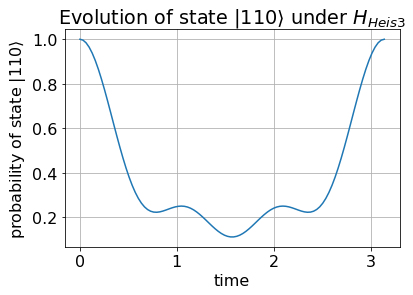

In [4]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

### 1-5 Decomposition of $U_{\text{Heis3}}(t)$ Into Quantum Gates

To execute $U_{\text{Heis3}}(t)$ on a [circuit model](https://qiskit.org/documentation/apidoc/circuit.html) quantum computer, we must decompose $U_{\text{Heis3}}(t)$ into a product of single and two-qubit gates that are native to that quantum computer. There are a [variety of techniques](https://en.wikipedia.org/wiki/Hamiltonian_simulation) to do this. For this Open Science Prize, you will only use [Trotterization](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas) (which is sometimes refered to as Suzuki-Trotterization decomposition, Trotter formulas, product formulas, and other names).

Below, we show an example Trotterization as outlined in \[1-2\].

Since the [Pauli operators do not commute](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) with each other, the exponential $U_{\text{Heis3}}(t)$ cannot be split into a product of simpler exponentials. However, we can approximate $U_{\text{Heis3}}(t)$ as a product of simpler exponentials through Trotterization. Consider a subsystem of 2 spin-1/2 particles within the larger 3 spin system. The Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) would be $H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. Rewritting $U_{\text{Heis3}}(t)$ in terms of the two possible subsystems within the total $N=3$ system you will simulate,

$$
U_{\text{Heis3}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right].
$$

$H^{(0,1)}_{\text{Heis2}}$ and $H^{(1,2)}_{\text{Heis2}}$ do not commute, so $U_{\text{Heis3}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{Heis2}}\right) \exp\left(-i t H^{(1,2)}_{\text{Heis2}} \right)$. But, this product decomposition can be approximated with Trotterization which says $U_{\text{Heis3}}(t)$ is approximately a short evolution of $H^{(0,1)}_{\text{Heis2}}$ (time = $t/n$) and followed by a short evolution of $H^{(1,2)}_{\text{Heis2}}$ (time = $t/n$) repeated $n$ times

$$
\begin{align}
U_{\text{Heis3}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n.
\end{align}
$$

$n$ is the number of Trotter steps, and as $n$ increases, the approximation becomes more accurate. (Note that how a untiary is split up into subsystems for Trotterization is not necessarily unique.) The decomposition goes further. Within each 2 spin subsystems, the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. This means we can decompose the exponential of a subsystem Hamiltonian ($H^{(i,j)}_{\text{Heis2}}$) into a product of even simpler exponentials getting us closer to a gate implementation of $U_{\text{Heis3}}(t)$

$$
\begin{align}
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}\right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)\right)\right]^{n} \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(0)}\sigma_z^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(1)}\sigma_z^{(2)}\right)\right]^{n}
\end{align}
$$

For simplicity, and to use more common notation, let's rename the products with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and $ZZ(2t) = \exp\left(-it \sigma_z\sigma_z\right)$ and rewrite the Trotterized $U_{\text{Heis3}}(t)$
$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n}
$$
And that's it! We have now approximately decomposed $U_{\text{Heis3}}(t)$ into two-qubit gates $XX(t)$, $YY(t)$, and $ZZ(t)$. These gates are not native to superconducting qubits, but in Section 2, they will be further decomposed into native single and two-qubit gates with *further details found in the supplementary material.*


\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]


# 2 The Open Science Prize
### 2-1 Contest Details
The Open Science Prize requirements and judging criteria can be found in the terms and conditions when registering on the [website](https://ibmquantumawards.bemyapp.com/#/event). Below is an outline of those requirements.

You are to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$ as defined in Section 1. This will be done on the ibmq_jakarta quantum computer. From left to right, the qubits in $|110\rangle$ correspond to ibmq_jakarta's qubits 5, 3, and 1. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$). You will be judged on the clarity, originiality, and creativity of your solution, as well as the fidelity of the evolved state at time $t=\pi$ using [state tomography](https://qiskit.org/documentation/tutorials/noise/8_tomography.html). State tomography is a way of determining the exact quantum state--even phase information--at the end of a quantum circuit by running the circuit multiple times and measuring in different bases. The closer your final quantum state to the expected state, the higher the fidelity. Ibmq_jakarta's qubits 0, 2, 4, and 6 will not be evaluated by the state tomography calculation, so you may use them as you wish. You do not need to follow the same decomposition given in the example above, but your solution must be a Trotterization of $U_{\text{heis3}}(t)$ with at least 4 steps ($n\geq4$). You may find it useful to implement techniques that reduce errors and improve qubit coherence.

### 2-2 Import Qiskit

Feel free to import packages as needed. However, only free packages and those obtained through ```pip install``` or ```conda install``` are allowed.

In [5]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Other
from copy import deepcopy

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 2-3 Quantum Devices
Connect to IBM provider and connect to a real or simulated backend. Final submissions must be run on a real backend, but simulated devices are faster for debugging and testing.

In [6]:
# load IBMQ Account data

# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()

In [7]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

### 2-4 Decomposition of $U_{\text{Heis3}}(t)$ into Quantum Gates (Example)

The following circuit code is written based on the example given in Section 1. This is where you write your solution.

MY TROTTERIZATION GOES HERE -- START

In [8]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')
t2 = Parameter('t2')

In [96]:
# Build the subcircuit for XX(t)YY(t)ZZ(t) two-qubit gate.
def xxyyzz_30():
    
    # IMPORTANT! This subcircuit is derived for t=30°
    qc = QuantumCircuit(2, name='xyz_30')
    
    # ZZ
    qc.cx(0,1)
    qc.rz(2*t, 1)
    
    # XXYY
    #qc.crx(2*(90-t),1,0)
    qc.crx(4*t,1,0)
    qc.cx(0,1)
    
    # This subcircuit represents "the building block" of a trotter step.
    return qc.to_gate()

def xxyyzz_15():
    
    # IMPORTANT! This subcircuit is derived for t=15°
    qc = QuantumCircuit(2, name='xyz_15')
    
    # ZZ
    qc.cx(0,1)
    qc.rz(2*t2, 1)
    
    # XXYY
    qc.crx(4*t2,1,0)
    qc.cx(0,1)
    
    # This subcircuit represents "the building block" of a trotter step.
    return qc.to_gate()

def c_xxyyzz_30():
    
    # IMPORTANT! This subcircuit is derived for t=30°
    qc = QuantumCircuit(3, name='c_xyz_30')
    
    # ZZ
    qc.cx(0,1)
    qc.crz(2*t, 2, 1)
    
    # XXYY
    qc.crx(4*t,1,0)
    qc.cx(0,1)
    
    # This subcircuit represents "the building block" of a trotter step.
    return qc.to_gate()

def c_xxyyzz_15():
    
    # IMPORTANT! This subcircuit is derived for t=15°
    qc = QuantumCircuit(3, name='c_xyz_15')
    
    # ZZ
    qc.cx(0,1)
    qc.crz(2*t2, 2, 1)
    
    # XXYY
    qc.crx(4*t2,1,0)
    qc.cx(0,1)
    
    # This subcircuit represents "the building block" of a trotter step.
    return qc.to_gate()

def AA_30():
    qc = QuantumCircuit(3, name='AA_30')
    
    qc.append(xxyyzz_30(), [0,1])
    qc.append(xxyyzz_30(), [1,2])
    
    return qc.to_gate()

def AB_30():
    qc = QuantumCircuit(3, name='AB_30')
    
    qc.append(xxyyzz_30(), [0,1])
    qc.append(xxyyzz_30(), [2,1])
    
    return qc.to_gate()

def BA_30():
    qc = QuantumCircuit(3, name='BA_30')
    
    qc.append(xxyyzz_30(), [1,0])
    qc.append(xxyyzz_30(), [1,2])
    
    return qc.to_gate()

def BB_30():
    qc = QuantumCircuit(3, name='BB_30')
    
    qc.append(xxyyzz_30(), [1,0])
    qc.append(xxyyzz_30(), [2,1])
    
    return qc.to_gate()

def AA_15():
    qc = QuantumCircuit(3, name='AA_15')
    
    qc.append(xxyyzz_15(), [0,1])
    qc.append(xxyyzz_15(), [1,2])
    
    return qc.to_gate()

def AB_15():
    qc = QuantumCircuit(3, name='AB_15')
    
    qc.append(xxyyzz_15(), [0,1])
    qc.append(xxyyzz_15(), [2,1])
    
    return qc.to_gate()

def BA_15():
    qc = QuantumCircuit(3, name='BA_15')
    
    qc.append(xxyyzz_15(), [1,0])
    qc.append(xxyyzz_15(), [1,2])
    
    return qc.to_gate()

def BB_15():
    qc = QuantumCircuit(3, name='BB_15')
    
    qc.append(xxyyzz_15(), [1,0])
    qc.append(xxyyzz_15(), [2,1])
    
    return qc.to_gate()
    

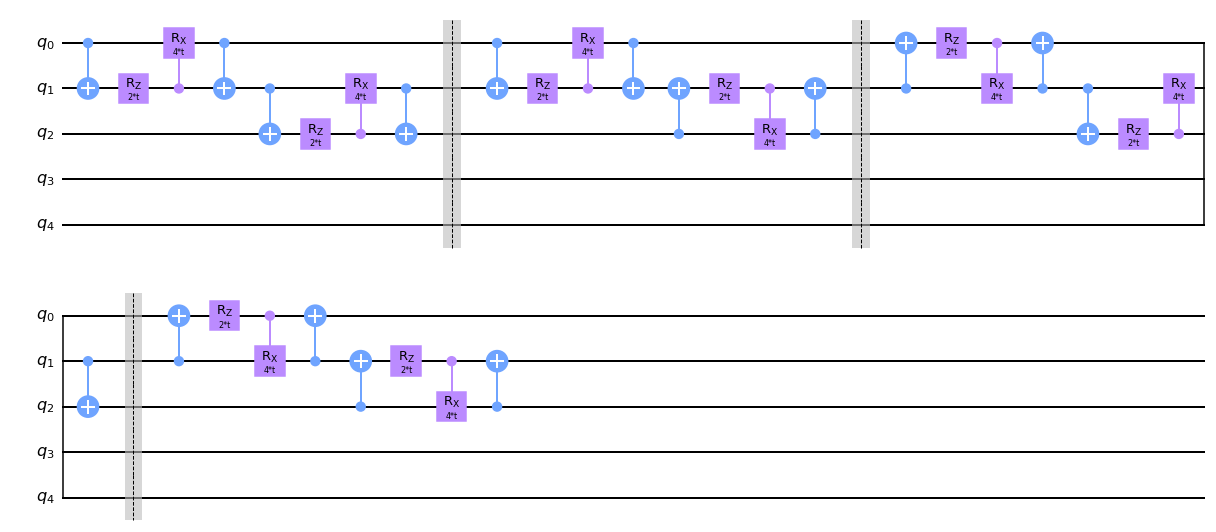

In [97]:
qc_test = QuantumCircuit(5)

qc_test.append(AA_30(), [0,1,2])
qc_test.barrier()
qc_test.append(AB_30(), [0,1,2])
qc_test.barrier()
qc_test.append(BA_30(), [0,1,2])
qc_test.barrier()
qc_test.append(BB_30(), [0,1,2])

qc_test.decompose().decompose().draw('mpl')

Combine subcircuits into single gate representing one ($n=1$) trotter step.

In [126]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3 # 3

#
# Make subcircuit for the angle = 30°
#
Trot_qr_30 = QuantumRegister(num_qubits)
Trot_qc_30 = QuantumCircuit(Trot_qr_30, name='Trot_30')

#for i in range(0, num_qubits - 1):
#    Trot_qc_30.append(xxyyzz_30(), [Trot_qr_30[i], Trot_qr_30[i+1]])

Trot_qc_30.append(AB_30(), [Trot_qr_30[0], Trot_qr_30[1], Trot_qr_30[2]])

    
#Trot_qc_30.append(c_xxyyzz_30(), [Trot_qr_30[2], Trot_qr_30[1], Trot_qr_30[0]])
#Trot_qc_30.append(c_xxyyzz_30(), [Trot_qr_30[2], Trot_qr_30[3], Trot_qr_30[4]])

# Convert custom quantum circuit into a gate
Trot_gate_30 = Trot_qc_30.to_instruction()

#
# Make subcircuit for the angle = 15°
#
Trot_qr_15 = QuantumRegister(num_qubits)
Trot_qc_15 = QuantumCircuit(Trot_qr_15, name='Trot_15')

#for i in range(0, num_qubits - 1):
#    Trot_qc_15.append(xxyyzz_15(), [Trot_qr_15[i], Trot_qr_15[i+1]])

Trot_qc_15.append(AB_15(), [Trot_qr_15[0], Trot_qr_15[1], Trot_qr_15[2]])
#Trot_qc_15.append(c_xxyyzz_15(), [Trot_qr_15[0], Trot_qr_15[1], Trot_qr_15[3]])
#Trot_qc_15.append(c_xxyyzz_15(), [Trot_qr_15[1], Trot_qr_15[2], Trot_qr_15[3]])

# Convert custom quantum circuit into a gate
Trot_gate_15 = Trot_qc_15.to_instruction()

MY TROTTERIZATION GOES HERE -- FINISH

### 2-5 Trotterized Time Evolution

Time evolve the state $|110\rangle$ from $\theta=0$ to $\theta=\pi$ under $H_{\text{heis3}}$. Although jakarta has 7 qubits, only the qubits 1, 3, and 5 will be used for the state $|110\rangle$. From left to right, the qubits in $|110\rangle$ corresponds to the qubits 5, 3, and 1 on jakarta. State tomography will evaluate how well the quantum simulation matches to the expected state at $\theta= \pi$. (Note qubits 0, 2, 4, and 6 are not part of the state tomography calculation.)

You choose how many trotter steps (```trotter_steps```) to take in the simulation, but it must be at least 4. The code below is written to be generic enough for you may add to it if necessary for your solution.

In [127]:
# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 6  ### IT HAS TO BE = 6 (case t=30) or = 12 (case t=15) FOR THE 'target_time = np.pi'

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

#qc.x([0,4])
#qc.h([0,4])
# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps-2):
    qc.append(Trot_gate_30, [qr[1], qr[3], qr[5]])
    
# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(4):
    qc.append(Trot_gate_15, [qr[1], qr[3], qr[5]])

#qc.h([0,4])

# Apply the basic error correction for qubits #1 and #5.
# We chose these qubits based on the physical connections between qubits in the "ibmq_jakarta" quantum computer.
#qc.cx(1,2)
#qc.cx(5,6)
qc.cx(1,0)
qc.cx(1,2)
qc.cx(5,4)
qc.cx(5,6)

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/trotter_steps})
qc = qc.bind_parameters({t2: target_time/(2*trotter_steps)})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
#st_qcs[-1].draw()  # only view trotter gates

In [128]:
# Add the classical register. The register is used for the error correction.
qst_orig = deepcopy(st_qcs)
cr = ClassicalRegister(4)
for qst_ghz_circ in st_qcs:
    qst_ghz_circ.add_register(cr)
    qst_ghz_circ.measure([qr[0], qr[2], qr[4], qr[6]], [cr[0], cr[1], cr[2], cr[3]])
    
st_qcs[-1].draw()

»
q21877_0: ────────────────────────────────────────────────────────»
               ┌───────────────┐┌───────────────┐┌───────────────┐»
q21877_1: ─────┤0              ├┤0              ├┤0              ├»
               │               ││               ││               │»
q21877_2: ─────┤               ├┤               ├┤               ├»
          ┌───┐│               ││               ││               │»
q21877_3: ┤ X ├┤1 Trot_30(π/6) ├┤1 Trot_30(π/6) ├┤1 Trot_30(π/6) ├»
          └───┘│               ││               ││               │»
q21877_4: ─────┤               ├┤               ├┤               ├»
          ┌───┐│               ││               ││               │»
q21877_5: ┤ X ├┤2              ├┤2              ├┤2              ├»
          └───┘└───────────────┘└───────────────┘└───────────────┘»
q21877_6: ────────────────────────────────────────────────────────»
                                                                  »
   c43: 3/════════════════════════════════════════════════════════»
                                                                  »
   c44: 4/════════════════════════════════════════════════════════»
                                                                  »
«                                                               »
«q21877_0: ─────────────────────────────────────────────────────»
«          ┌───────────────┐┌────────────────┐┌────────────────┐»
«q21877_1: ┤0              ├┤0               ├┤0               ├»
«          │               ││                ││                │»
«q21877_2: ┤               ├┤                ├┤                ├»
«          │               ││                ││                │»
«q21877_3: ┤1 Trot_30(π/6) ├┤1 Trot_15(π/12) ├┤1 Trot_15(π/12) ├»
«          │               ││                ││                │»
«q21877_4: ┤               ├┤                ├┤                ├»
«          │               ││                ││                │»
«q21877_5: ┤2              ├┤2               ├┤2               ├»
«          └───────────────┘└────────────────┘└────────────────┘»
«q21877_6: ─────────────────────────────────────────────────────»
«                                                               »
«   c43: 3/═════════════════════════════════════════════════════»
«                                                               »
«   c44: 4/═════════════════════════════════════════════════════»
«                                                               »
«                                              ┌───┐      ░          ┌─┐      »
«q21877_0: ────────────────────────────────────┤ X ├──────░──────────┤M├──────»
«          ┌────────────────┐┌────────────────┐└─┬─┘      ░ ┌─┐      └╥┘      »
«q21877_1: ┤0               ├┤0               ├──■────■───░─┤M├───────╫───────»
«          │                ││                │     ┌─┴─┐ ░ └╥┘       ║ ┌─┐   »
«q21877_2: ┤                ├┤                ├─────┤ X ├─░──╫────────╫─┤M├───»
«          │                ││                │     └───┘ ░  ║ ┌─┐    ║ └╥┘   »
«q21877_3: ┤1 Trot_15(π/12) ├┤1 Trot_15(π/12) ├───────────░──╫─┤M├────╫──╫────»
«          │                ││                │┌───┐      ░  ║ └╥┘    ║  ║ ┌─┐»
«q21877_4: ┤                ├┤                ├┤ X ├──────░──╫──╫─────╫──╫─┤M├»
«          │                ││                │└─┬─┘      ░  ║  ║ ┌─┐ ║  ║ └╥┘»
«q21877_5: ┤2               ├┤2               ├──■────■───░──╫──╫─┤M├─╫──╫──╫─»
«          └────────────────┘└────────────────┘     ┌─┴─┐ ░  ║  ║ └╥┘ ║  ║  ║ »
«q21877_6: ─────────────────────────────────────────┤ X ├─░──╫──╫──╫──╫──╫──╫─»
«                                                   └───┘ ░  ║  ║  ║  ║  ║  ║ »
«   c43: 3/══════════════════════════════════════════════════╩══╩══╩══╬══╬══╬═»
«                                                            0  1  2  ║  ║  ║ »
«   c44: 4/═══════════════════════════════════════════════════════════╩══╩══╩═»
«                                                                     0  1  2 »


### 2-6 Execute
For your final submission, you will need to execute your solution on a real backend with 8 repetitions. For faster debugging, considering using a simulated backend and/or 1 repetition.

In [141]:
shots = 8192
reps = 2
backend = sim_noisy_jakarta
#reps = 8
#backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots, optimization_level=3)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 6daf6cbb-f933-4111-8034-ec1880e17076
Job ID 2545518b-1381-4e23-93e9-3375e56de2ab


We can monitor the status of the jobs using Qiskit's job monitoring tools.

In [132]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has been cancelled
Job Status: job has been cancelled


### 2-7 Results Analysis
Extract the results for the completed jobs and compute the state tomography fidelity for each repetition. You may choose to include other post-processing analyses here as well.

In [137]:
#
# POST-PROCESSING
#
# Remove corrupted results from the statistics
def result_filter(raw_results, new_results):

    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}

        # Change the size of the classical register
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:3]
        new_results.results[resultidx].header.memory_slots = 3

        # Filter the results
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            #print(reg_bits)
            
            # DON'T FORGET, REVERSE ORDER OF BITS! FROM LEFT TO RIGHT!
            # Our case:
            #            4. Classical bit [0][0] should be the same as the 3. Tomography bit [1][0]
            #            3. Classical bit [0][1] should be the same as the 3. Tomography bit [1][0]
            #            2. Classical bit [0][2] should be the same as the 1. Tomography bit [1][2]
            #            1. Classical bit [0][3] should be the same as the 1. Tomography bit [1][2]
            if reg_bits[0][0]==reg_bits[1][0] and reg_bits[0][1]==reg_bits[1][0] and reg_bits[0][2]==reg_bits[1][2] and reg_bits[0][3]==reg_bits[1][2]:
                #if reg_bits[0][0]==reg_bits[1][0] and reg_bits[0][1]=='1' and reg_bits[0][2]==reg_bits[1][2] and reg_bits[0][3]=='1': 
                new_counts[reg_bits[1]]=old_counts[reg_key]
                #print('j')
                #print(reg_bits)

        new_results.results[resultidx].data.counts = new_counts

In [142]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    
    # Implement the post-processing of results
    current_results = job.result()
    filtered_results = deepcopy(current_results)    
    result_filter(current_results, filtered_results)

    # Apply the state tomography with the filtered results
    fid = state_tomo(filtered_results, qst_orig)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.4556 ± 0.0018


In [17]:
import qiskit.tools.jupyter
%qiskit_version_table